# A/B-тест в интернет-магазине

## Описание проекта

Для отдела маркетинга крупного интернет-магазина нужно провести приоритизацию гипотез по увеличению выручки. После выбора наиболее важной гипотезы и её проверки в течение месяца с помощью A/B-теста, нужно проанализировать результаты и принять решение об остановке или продолжении теста.

Проект разделён на две части:
- Часть 1. Приоритизация гипотез. Задачи: применить фреймворки ICE и RICE для приоритизации гипотез, оценить отличие в результатах фреймворков, выбрать наиболее важную гипотезу для проверки.
- Часть 2. Анализ A/B-теста. Задачи: рассчитать и построить графики кумулятивной выручки, среднего чека и конверсии для "сырых" и "очищенных" от выбросов данных, оценить статистическую значимость различий в рассчитанных метриках.

Для выполнения части 1 нам предоставлен список гипотез и параметры для их сравнения. Для выполнения части 2 у нас есть данные о посещениях и заказах двух групп: контрольной (A) и тестовой (B).

## <a name="0"> Структура проекта </a>

Проект содержит следующие разделы:
- [Часть 1. Приоритизация гипотез](#1)
  - [Загрузка данных и ознакомление с ними](#2)
  - [Приоритизация с помощью фреймворков ICE и RICE](#3)
  - [Выводы по итогам приоритизации гипотез](#4)
- [Часть 2. Анализ A/B-теста](#5)
  - [Загрузка данных и ознакомление с ними](#6)
  - [Предобработка данных](#7)
  - [Исследование данных](#8)
    - [Проверка однородности трафика](#9)
    - [Проверка на наличие покупателей, попавших в обе группы](#10)
    - [Проверка на наличие выбросов](#11)
    - [Кумулятивная выручка](#12)
    - [Кумулятивный средний чек](#13)
    - [Кумулятивная конверсия](#14)
  - [Выводы по итогам анализа A/B-теста](#15)

## <a name="1"> Часть 1. Приоритизация гипотез </a>

### <a name="2"> Загрузка данных и ознакомление с ними </a>

Загрузим библиотеки, которые понадобятся для работы с данными:

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as st 
from statsmodels.stats.proportion import proportions_ztest

Загрузим данные о гипотезах по увеличению выручки интернет-магазина и посмотрим на них:

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Так как гипотезы в ячейках таблицы видны не полностью, установим ширину ячеек такой, чтобы строки помещались без сокращения:

In [3]:
pd.set_option('display.max_colwidth', -1)

Проверим:

In [4]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Теперь все гипотезы видны и с ними можно ознакомиться.

Все гипотезы звучат разумно, поэтому чтобы понять, какую проверять в первую очередь, воспользуемся фреймворками ICE и RICE - одними из самых популярных способов приоритизации задач. Как раз для их расчёта в таблице есть 4 параметра:
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

### <a name="3"> Приоритизация с помощью фреймворков ICE и RICE </a>

Рассчитаем для каждой гипотезы значения ICE и RICE, воспользуемся следующими формулами:

$$ICE = \frac{Impact * Confidence}{Efforts}$$ 

$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$

Рассчитанные значения ICE и RICE добавим в таблицу hypothesis:

In [5]:
hypothesis['ICE'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] \
                    / hypothesis['Efforts']
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2


Отсортируем таблицу по значению ICE, от большего к меньшему. Посмотрим на порядок приоритетности гипотез согласно этому фреймворку:

In [6]:
hypothesis.sort_values('ICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


Теперь отсортируем таблицу по значению RICE. Посмотрим на порядок приоритетности гипотез согласно этому фреймворку:

In [7]:
hypothesis.sort_values('RICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


### <a name="4"> Выводы по итогам приоритизации гипотез </a>

Можно увидеть, что в пятёрку самых важных гипотез по обоим фреймворкам попали одни и те же гипотезы (индексы 0, 2, 6, 7, 8), но в разном порядке. Для расчёта ICE не используется параметр Reach, поэтому гипотезе с индексом 8 удалось занять первое место при этом способе приоритизации. Изменение согласно этой гипотезе окажет большое влияние на пользователей при умеренных расходах на её проверку. 

Во фреймворке RICE наиболее важной оказалась гипотеза с индексом 7 благодаря высокому значению параметра Reach. Изменение согласно этой гипотезе не окажет такого сильного влияния на пользователей, как изменение в гипотезе 8. Однако оно охватит бóльшую долю пользователей. 

Фреймворк RICE учитывает больше данных, чем ICE. Если изменения в гипотезах затрагивают разные объёмы аудитории бизнеса, то его применение предпочтительнее. Именно поэтому гипотезу 7 нужно проверить в первую очередь.

Единогласным аутсайдером по обоим фреймворкам является гипотеза с индексом 4 - она последняя в списке важности. Несмотря на то, что её проверка стоит меньше всего, изменение согласно этой гипотезе окажет крайне низкое влияние и лишь на небольшую долю пользователей. Да и то это не точно.

[К началу](#0)

## <a name="5"> Часть 2. Анализ A/B-теста </a>

### <a name="6"> Загрузка данных и ознакомление с ними </a>

По результатам A/B-теста выбранной гипотезы были получены результаты, которые описаны в таблицах orders и visitors. 

Загрузим таблицу orders:

In [8]:
orders = pd.read_csv('/datasets/orders.csv')
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


Таблица orders содержит следующие столбцы:
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Проверим типы данных и наличие пропусков:

In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


В таблице 1197 строк, пропусков нет. Тип данных в столбце date правильнее привести к типу datetime. Сделаем это на этапе предобработки данных.

Проверим интервал времени, когда были сделаны заказы:

In [10]:
orders['date'].min(), orders['date'].max()

('2019-08-01', '2019-08-31')

Теперь загрузим таблицу visitors:

In [11]:
visitors = pd.read_csv('/datasets/visitors.csv')
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


Таблица visitors содержит следующие столбцы:
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

Проверим типы данных и наличие пропусков:

In [12]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


В таблице 62 строки, пропусков нет. Тип данных в столбце date правильнее привести к типу datetime. Сделаем это на этапе предобработки данных.

Проверим интервал времени, когда проходил A/B-тест:

In [13]:
visitors['date'].min(), visitors['date'].max()

('2019-08-01', '2019-08-31')

По итогам ознакомления с данными в таблицах orders и visitors можно сделать следующие выводы:
- данные предоставлены за период с 1 по 31 августа 2019 года;
- в таблице orders 1197 строк - столько было сделано заказов (при условии, что в таблице нет дублей);
- в таблице visitors 62 строки - это говорит о том, что у нас есть записи для каждой группы (A и B) в каждый день августа (2 * 31 = 62) при условии, что в таблице нет дублей и пропусков дат или других проблем;
- данные о времени в столбцах date обеих таблиц правильнее изменить с типа object на тип datetime. Это оптимизирует занятую память и позволит комфортнее работать с датами при необходимости.

### <a name="7"> Предобработка данных </a>

Заменим тип данных в столбцах date таблиц orders и visitors с object на datetime:

In [14]:
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')

Проверим, что тип данных поменялся:

In [15]:
orders['date'].dtype, visitors['date'].dtype

(dtype('<M8[ns]'), dtype('<M8[ns]'))

Всё верно: тип <M8[ns] является разновидностью типа времени datetime:

In [16]:
type('<M8[ns]') == type('datetime64[ns]')

True

Проверим, действительно ли в столбцах date есть все дни августа (31 день):

In [17]:
orders['date'].nunique(), visitors['date'].nunique()

(31, 31)

Теперь проверим таблицы orders и visitors на наличие дубликатов:

In [18]:
orders.duplicated().sum(), visitors.duplicated().sum()

(0, 0)

Полных дубликатов нет. Проверим, есть ли дубли id заказов в orders:

In [19]:
orders['transactionId'].duplicated().sum()

0

Дублей в таблицах нет.

По результатам предобработки данных:
- был изменён тип данных в столбцах date обеих таблиц с типа object на тип datetime;
- проверили, что в столбцах date обеих таблиц нет пропусков дней августа, есть все 31 день;
- проверили таблицы на наличие дублей: их нет.

### <a name="8"> Исследование данных </a>

#### <a name="9"> Проверка однородности трафика </a>

Посмотрим, насколько однородно трафик "лился" по группам A и B. Не было ли дней с перекосом трафика в сторону одной из групп. Насколько равны группы по объёму.

Сравним общее количество посетителей в группе A и B:

In [20]:
visitors_A = visitors.query('group == "A"')['visitors'].sum()
visitors_B = visitors.query('group == "B"')['visitors'].sum()
visitors_A, visitors_B

(18736, 18916)

В группе B немного больше посетителей, найдём разницу:

In [21]:
(visitors_B - visitors_A) / visitors_A

0.009607173356105893

Относительная разница в группах незначительная, меньше 1%.

Проверим, как посетители попадали в группы в зависимости от дня месяца. Важно, чтобы не получилось так, что в одни дни больше посетителей попадало в одну группу, а в другие дни - в другую группу. Например, если в одной из групп будет больше "выходных" посетителей, то это может оказать влияние на конверсию или средний чек.

Развернём таблицу visitors так, чтобы индексами были даты, в столбцах - названия групп, а в ячейках - количество посетителей:

In [22]:
daily_traffic = visitors.pivot_table(index='date', columns='group', values='visitors', aggfunc='mean')
daily_traffic.head()

group,A,B
date,,
2019-08-01,719,713
2019-08-02,619,581
2019-08-03,507,509
2019-08-04,717,770
2019-08-05,756,707


Построим линейный график дневного трафика для групп A и B:

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


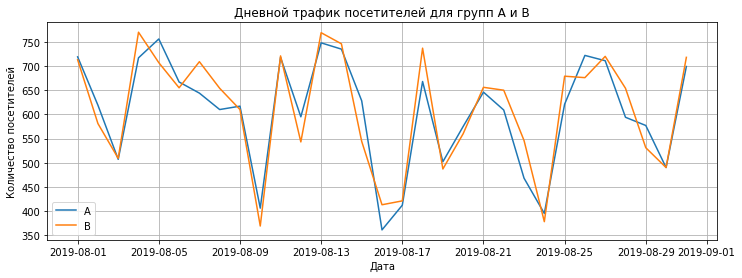

In [23]:
plt.figure(figsize=(12, 4))
plt.plot(daily_traffic['A'], label='A')
plt.plot(daily_traffic['B'], label='B')
plt.legend()
plt.grid()
plt.title("Дневной трафик посетителей для групп A и B")
plt.xlabel("Дата")
plt.ylabel("Количество посетителей")
plt.show() 

Трафик "льётся" однородно: кривые идут близко одна к другой. 

#### <a name="10"> Проверка на наличие покупателей, попавших в обе группы </a>

Посчитаем количество покупателей в группах A и B. Для этого сгруппируем таблицу orders по visitorId и group (найдём сочетания "покупатель-группа"), а затем посчитаем покупателей с группой A и покупателей с группой B:

In [24]:
temp = orders.groupby(['visitorId','group'])[['transactionId']].count().reset_index()
# делаем расчёт количества транзакций просто потому, что фукнция groupby требует что-то поссчитать для групп
temp['group'].value_counts()

B    586
A    503
Name: group, dtype: int64

Видим, что в группе B больше покупателей. Посчитаем, насколько группа B больше группы A:

In [25]:
(temp['group'].value_counts()[0] - temp['group'].value_counts()[1]) / temp['group'].value_counts()[1]

0.16500994035785288

Группа B больше на 16,5%. 

Теперь посмотрим, есть ли среди покупателей такие, которые попали в группу A и B одновременно. Для этого сгруппируем таблицу orders по visitorId, посчитаем количество уникальных значений в group и выведем количество тех покупателей, у которых больше одной группы:

In [26]:
groups_by_visitors = orders.groupby('visitorId')['group'].nunique()
incorrect_visitors = groups_by_visitors[groups_by_visitors > 1]
len(incorrect_visitors)

58

Получилось, что 58 покупателей попали сразу в две группы: A и B. К сожалению, это означает, что покупатели успели провзаимодействовать с обеими версиями сайта - тестовой и контрольной, и мы не знаем, какая из версий в какой степени сподвигла их совершить заказ. Поэтому придётся этих покупателей и их заказы исключить из теста.

Мы поймали только тех 58 пользователей, которые совершили заказ из обеих групп. В связи с этим возникает опасение, что были пользователи, которые видели две версии сайта и совершили только один заказ, который был привязан к одной из групп. Фактически это будет некорректный учёт. Чтобы проверить это опасение, надо изучить, посетителями с какими id наполнены группы в таблице visitors. Нет ли там посетителей, которые попали в обе группы. Так как в рамках проекта у нас нет таких данных, то будем считать, что таблица visitors не имеет подобных ошибок.

Исключим 58 покупателей и их заказы из таблицы orders:

In [27]:
new_orders = orders.query('visitorId not in @incorrect_visitors.index')
new_orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


Теперь таблица очищена от покупателей, оказавшихся в обеих группах - контрольной и тестовой.

Посмотрим, как поменялось количество покупателей в группах A и B:

In [28]:
temp = new_orders.groupby(['visitorId','group'])[['transactionId']].count().reset_index()
temp['group'].value_counts()

B    528
A    445
Name: group, dtype: int64

В группе B по-прежнему больше покупателей. Посчитаем различие:

In [29]:
(temp['group'].value_counts()[0] - temp['group'].value_counts()[1]) / temp['group'].value_counts()[1]

0.18651685393258427

Немного возросло: теперь в группе B на 18,7% больше покупателей.

Так как количество посетителей в группах было примерно одинаковым, то уже можно сказать, что конверсия посетителей в покупатели у группы B оказалась лучше. Пока не ясно, это простая флуктуация конверсии или статистически значимое различие. Выясним это позже.

[К началу](#0)

#### <a name="11"> Проверка на наличие выбросов </a>

Проверим, есть ли в данных выбросы. Если найдём их, то сравнивать группы будем по "сырым" данным, с выбросами, и "очищенным", без выбросов. Так мы сможем понять, какое влияние оказывают выбросы на результаты групп. 

Изучим распределение количества заказов у покупателей. Посчитаем, сколько у нас уникальных покупателей и какое количество заказов каждый из них сделал:

In [30]:
orders_by_visitors = new_orders.groupby('visitorId')['transactionId'].nunique()
orders_by_visitors.sort_values(ascending=False)

visitorId
249864742     3
3908431265    3
2742574263    3
3967698036    3
611059232     3
             ..
2771749575    1
2763027084    1
2761566146    1
2758621772    1
5114589       1
Name: transactionId, Length: 973, dtype: int64

В таблице 973 покупателя. Есть такие, которые сделали по 3 заказа. Посмотрим на распределение количества заказов:

In [31]:
orders_by_visitors.describe()

count    973.000000
mean     1.044193  
std      0.238090  
min      1.000000  
25%      1.000000  
50%      1.000000  
75%      1.000000  
max      3.000000  
Name: transactionId, dtype: float64

Среднее значение - около 1 заказа, медианное - 1 заказ. Не менее 75% покупателей делают лишь 1 заказ.

Построим гистограмму:

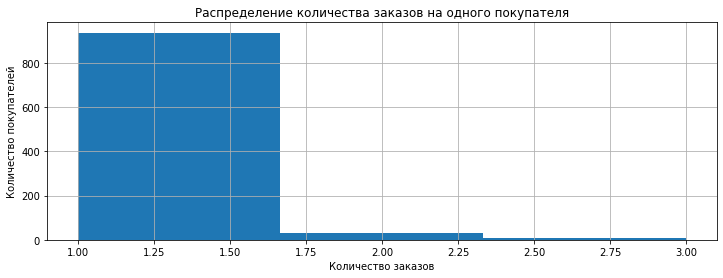

In [32]:
plt.figure(figsize=(12, 4))
plt.hist(orders_by_visitors, bins=3)
plt.grid()
plt.title("Распределение количества заказов на одного покупателя")
plt.xlabel("Количество заказов")
plt.ylabel("Количество покупателей")
plt.show() 

Видно, что лишь небольшое количество покупателей делают 2 и 3 заказа. 

Построим диаграмму рассеяния количества заказов и покупателей. Для этого по оси абсцисс отложим порядковые номера следования покупателей в orders_by_visitors, а по оси ординат - количество совершённых заказов:

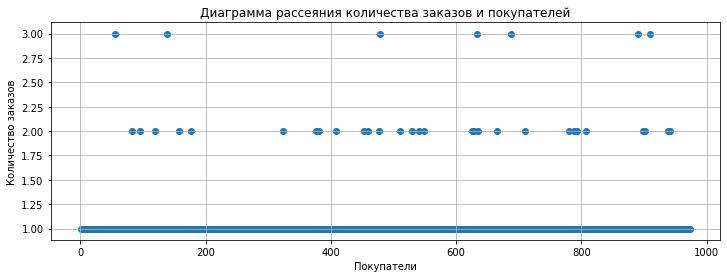

In [33]:
x_values = pd.Series(range(1, len(orders_by_visitors) + 1))
plt.figure(figsize=(12, 4))
plt.scatter(x_values, orders_by_visitors) 
plt.grid()
plt.title("Диаграмма рассеяния количества заказов и покупателей")
plt.xlabel("Покупатели")
plt.ylabel("Количество заказов")
plt.show() 

Покупателей с 3 заказами можно даже сосчитать - их 7 человек. А всего покупателей 973. 7 человек от 973 - это мало. Если быть точнее - меньше 1%. Найдём этих семерых:

In [34]:
outlier_visitors = orders_by_visitors[orders_by_visitors > 2].index
outlier_visitors

Int64Index([ 249864742,  611059232, 2108163459, 2742574263, 2988190573,
            3908431265, 3967698036],
           dtype='int64', name='visitorId')

Для проверки, найдём 95 и 99 процентили:

In [35]:
np.percentile(orders_by_visitors, [95, 99])

array([1., 2.])

Несмотря на то, что покупателей с 3 заказами меньше 1%, не будем считать их выбросами. Во-первых, это не сильное отклонение от основной массы покупателей, как могли бы быть покупатели с 5, 9 или 15 заказами. И поэтому они не окажут сильного влияния на итоговые результаты. А во-вторых, так мы сохраним больше данных для анализа.

Теперь изучим распределение выручки с заказов. Посмотрим, есть ли выбросы здесь.

In [36]:
new_orders['revenue'].describe()

count    1.016000e+03
mean     8.300815e+03
std      4.212199e+04
min      5.000000e+01
25%      1.190000e+03
50%      2.955000e+03
75%      8.134250e+03
max      1.294500e+06
Name: revenue, dtype: float64

Средний заказ приносит 8300 (средний чек), а медианный заказ - 2955. Видно, что максимальное значение - сильный выброс. 

Посмотрим, как выглядит распределение, построим гистограмму:

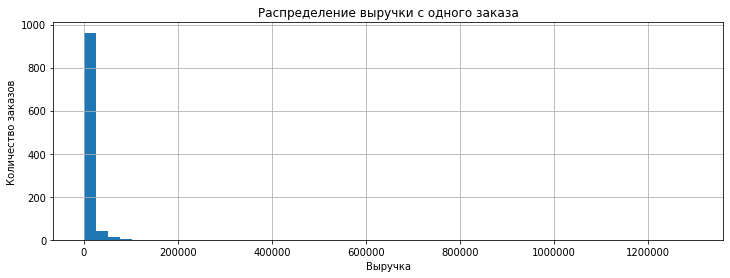

In [37]:
plt.figure(figsize=(12, 4))
plt.hist(new_orders['revenue'], bins=50)
plt.grid()
plt.title("Распределение выручки с одного заказа")
plt.xlabel("Выручка")
plt.ylabel("Количество заказов")
plt.show()

Распределение сильно сжато у нуля, это связано с выбросом максимального значения.

Построим диаграмму рассеяния выручки и заказов. Для этого по оси абсцисс отложим порядковые номера следования заказов в new_orders, а по оси ординат - выручку с каждого заказа:

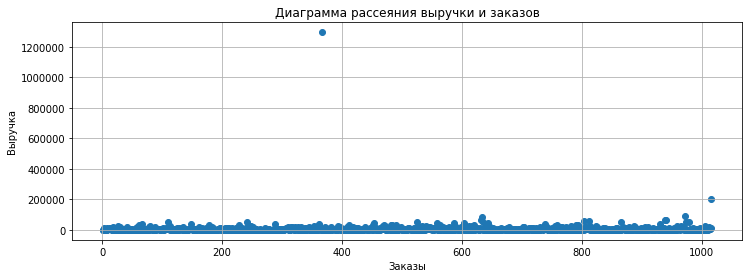

In [38]:
x_values = pd.Series(range(1, len(new_orders) + 1))
plt.figure(figsize=(12, 4))
plt.scatter(x_values, new_orders['revenue']) 
plt.grid()
plt.title("Диаграмма рассеяния выручки и заказов")
plt.xlabel("Заказы")
plt.ylabel("Выручка")
plt.show() 

Выделяются два значения - около 1 300 000 и 200 000. 2 заказа из 1016. Это меньше 0,2%. Для проверки найдём 95 и 99 процентили:

In [39]:
np.percentile(new_orders['revenue'], [95, 99])

array([26785., 53904.])

Посмотрим на топ-5 выбросов:

In [40]:
new_orders['revenue'].sort_values(ascending=False).head()

425     1294500
1196    202740 
1136    92550  
744     86620  
743     67990  
Name: revenue, dtype: int64

В качестве границы нормальных значений выберем значение 100 000. Оно отсечёт два явных выброса, при этом сохранит максимальное количество данных.

Так как оценивать группы мы будем по "сырым" и "очищенным" данным, то нужно составить соответствующие таблицы. Таблица с "сырыми" данными у нас уже есть - new_orders. Создадим таблицу new_orders_filtered с "очищенными" данными. Для этого исключим из new_orders заказы с выручкой более 100 000:

In [41]:
new_orders_filtered = new_orders.query('revenue <= 100000')

Посмотрим, как изменилось количество заказов:

In [42]:
len(new_orders), len(new_orders_filtered)

(1016, 1014)

С выбросами 1016 заказов, без выбросов - 1014. 2 заказа дороже 100 000 были удалены.

[К началу](#0)

#### <a name="12"> Кумулятивная выручка </a>

Рассчитаем кумулятивную выручку для групп по "сырым" данным. Развернём таблицу new_orders так, чтобы индексами были даты, в столбцах - названия групп, а в ячейках - суммарная выручка:

In [43]:
revenue_by_date = new_orders.pivot_table(index='date', columns='group', values='revenue', aggfunc='sum')
revenue_by_date.head()

group,A,B
date,,
2019-08-01,142779,59758
2019-08-02,91602,162043
2019-08-03,112473,67049
2019-08-04,41176,96890
2019-08-05,86383,89908


Чтобы выручка считалась нарастающим итогом по строкам, применим функцию cumsum() с аргументом axis=0:

In [44]:
revenue_cum = revenue_by_date.cumsum(axis=0)
revenue_cum.tail()

group,A,B
date,,
2019-08-27,2940471,4579312
2019-08-28,3036933,4640510
2019-08-29,3233233,4746610
2019-08-30,3311413,4955833
2019-08-31,3364656,5068972


Построим график кумулятивной выручки по группам:

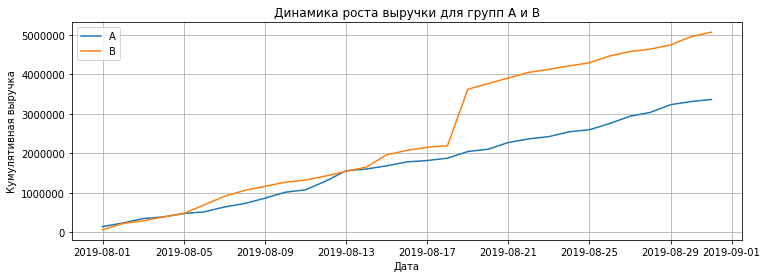

In [45]:
plt.figure(figsize=(12, 4))
plt.plot(revenue_cum['A'], label='A')
plt.plot(revenue_cum['B'], label='B')
plt.legend()
plt.title("Динамика роста выручки для групп A и B")
plt.xlabel("Дата")
plt.ylabel("Кумулятивная выручка") 
plt.grid()
plt.show()

По графику видно, что был сильный рост выручки в группе B 19 августа. Скорее всего в этот день как раз произошёл выброс с заказом на 1 294 500. Проверим, действительно ли он был в этот день:

In [46]:
new_orders.query('date == "2019-08-19" and revenue > 1000000')

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B


Да, вот этот дорогостоящий заказ-выброс.

Посмотрим на динамику роста выручки для групп без учёта выбросов. Построим график по "очищенным" данным:

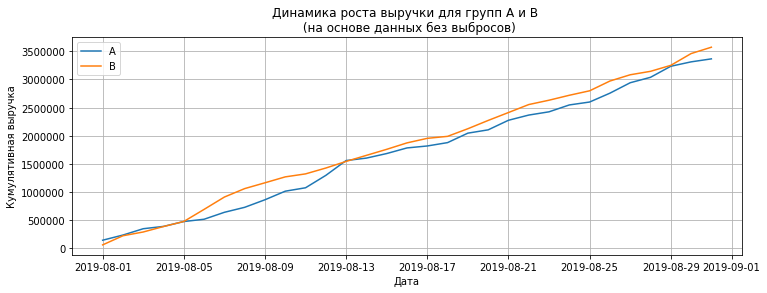

In [47]:
revenue_cum_filtered = new_orders_filtered.pivot_table(index='date', columns='group', 
                                                       values='revenue', aggfunc='sum').cumsum(axis=0)
plt.figure(figsize=(12, 4))
plt.plot(revenue_cum_filtered['A'], label='A')
plt.plot(revenue_cum_filtered['B'], label='B')
plt.legend()
plt.title("Динамика роста выручки для групп A и B \n (на основе данных без выбросов)")
plt.xlabel("Дата")
plt.ylabel("Кумулятивная выручка") 
plt.grid()
plt.show()

Так динамика выглядит намного естественнее. Группа B немного лучше себя ведёт по итоговой накопленной выручке, однако совсем незначительно: кривые идут параллельно и в нескольких точках даже сходятся. 

Посчитаем, насколько накопленная выручка группы B оказалась выше:

In [48]:
(revenue_cum['B'][-1] - revenue_cum['A'][-1]) / revenue_cum['A'][-1]

0.5065349919872938

Накопленная выручка в группе B на 51% выше, чем в группе A - на основе "сырых" данных.

In [49]:
(revenue_cum_filtered['B'][-1] - revenue_cum_filtered['A'][-1]) / revenue_cum_filtered['A'][-1]

0.06154447884122478

Накопленная выручка в группе B на 6% выше, чем в группе A - на основе "очищенных" данных. Не так впечатляюще, как на основе "сырых" данных.

Если вспомнить, что группа B на 1% больше группы A по количеству посетителей, то сделаем поправку и будем считать прирост кумулятивной выручки равным 5%.

[К началу](#0)

#### <a name="13"> Кумулятивный средний чек </a>

Для расчёта кумулятивного среднего чека нам нужна кумулятивная выручка (уже посчитана, таблица revenue_cum) и кумулятивное количество заказов. Составим таблицу с кумулятивными заказами:

In [50]:
orders_cum = new_orders.pivot_table(index='date', columns='group',
                                    values='transactionId', aggfunc='nunique').cumsum(axis=0)
orders_cum.head()

group,A,B
date,,
2019-08-01,23,17
2019-08-02,42,40
2019-08-03,66,54
2019-08-04,77,68
2019-08-05,99,89


Теперь поделим значения в таблице revenue_cum на значения в таблице orders_cum:

In [51]:
average_check_cum = revenue_cum / orders_cum
average_check_cum.tail()

group,A,B
date,,
2019-08-27,7017.830549,9681.420719
2019-08-28,6997.541475,9374.767677
2019-08-29,7169.031042,9307.078431
2019-08-30,7198.723913,9333.018832
2019-08-31,7189.435897,9249.948905


Построим график кумулятивного среднего чека по "сырым" данным:

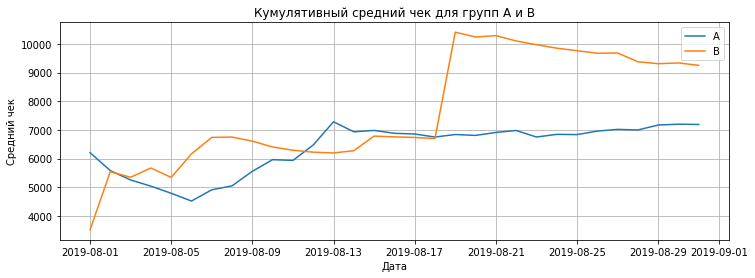

In [52]:
plt.figure(figsize=(12, 4))
plt.plot(average_check_cum['A'], label='A')
plt.plot(average_check_cum['B'], label='B')
plt.legend()
plt.title("Кумулятивный средний чек для групп A и B")
plt.xlabel("Дата")
plt.ylabel("Средний чек") 
plt.grid()
plt.show()

Видно, что в группе B средний чек резко вырос 19 августа. Такой же скачок в этой группе в эту дату мы видели на графике накопленной выручки. Это опять тот самый дорогостоящий заказ-выброс. 

Чтобы нивелировать влияние выбросов, построим график по "очищенным" данным:

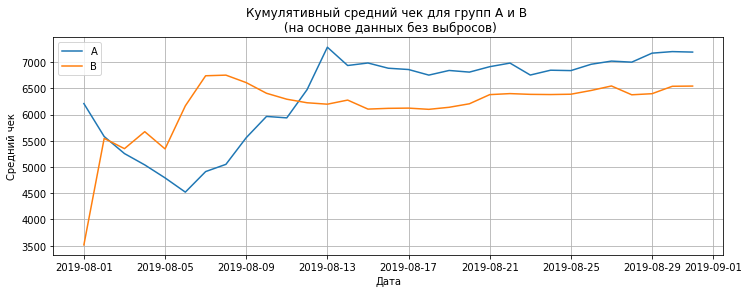

In [53]:
orders_cum_filtered = new_orders_filtered.pivot_table(index='date', columns='group',
                                    values='transactionId', aggfunc='nunique').cumsum(axis=0)
average_check_cum_filtered = revenue_cum_filtered / orders_cum_filtered
plt.figure(figsize=(12, 4))
plt.plot(average_check_cum_filtered['A'], label='A')
plt.plot(average_check_cum_filtered['B'], label='B')
plt.legend()
plt.title("Кумулятивный средний чек для групп A и B \n (на основе данных без выбросов)")
plt.xlabel("Дата")
plt.ylabel("Средний чек") 
plt.grid()
plt.show()

Без выбросов картина совсем другая: средний чек группы A сходится возле 7000, а средний чек группы B - возле 6500. Кажется, средний чек упал в тестовой группе.

Построим график относительного изменения кумулятивного среднего чека группы B к группе A. Сначала по "сырым" данным: 

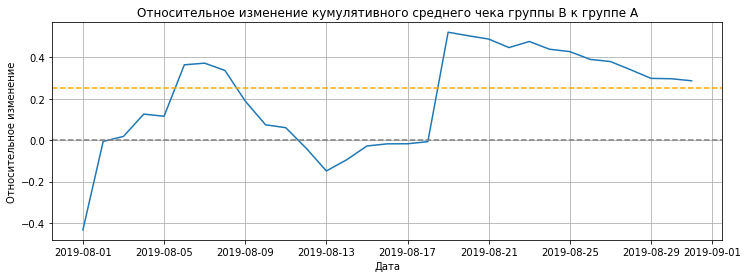

In [54]:
average_check_cum['diff'] = (average_check_cum['B'] - average_check_cum['A']) \
                            / average_check_cum['A']
plt.figure(figsize=(12, 4))
plt.plot(average_check_cum['diff'])
plt.axhline(y=0, color='grey', linestyle='--')
plt.axhline(y=.25, color='orange', linestyle='--') 
plt.title("Относительное изменение кумулятивного среднего чека группы B к группе A")
plt.xlabel("Дата")
plt.ylabel("Относительное изменение") 
plt.grid()
plt.show()

Теперь по "очищенным" данным:

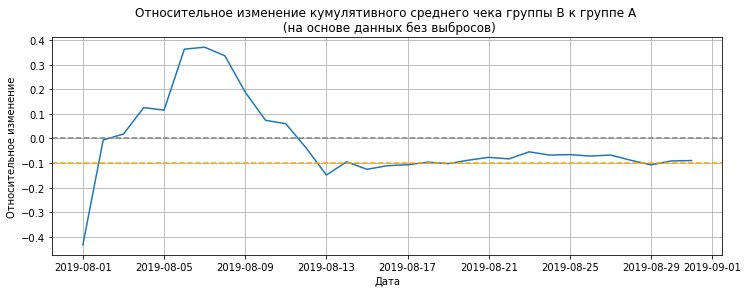

In [55]:
average_check_cum_filtered['diff'] = (average_check_cum_filtered['B'] - 
                                      average_check_cum_filtered['A']) / average_check_cum_filtered['A']
plt.figure(figsize=(12, 4))
plt.plot(average_check_cum_filtered['diff'])
plt.axhline(y=0, color='grey', linestyle='--') 
plt.axhline(y=-.1, color='orange', linestyle='--') 
plt.title("Относительное изменение кумулятивного среднего чека группы B к группе A \n (на основе данных без выбросов)")
plt.xlabel("Дата")
plt.ylabel("Относительное изменение") 
plt.grid()
plt.show()

Можно заключить, что средний чек группы B ниже среднего чека группы A примерно на 10% по данным без выбросов. Выясним, является ли это случайностью или статистически значимым различием. Для этого нужно сделать три вещи:
- сформулировать нулевую и альтернативную гипотезу;
- выбрать статистический критерий, с помощью которого мы будем отвергать и принимать гипотезы;
- принять критическое значение альфа, которое определяет границу между значимыми и незначимыми различиями.

Сформулируем гипотезы: 

Нулевая гипотеза (H0): стоимости заказов обеих групп относятся к общей генеральной совокупности с единым общим средним чеком, а полученное различие в кумулятивном среднем чеке для групп является случайным.

Альтернативная гипотеза (H1): стоимости заказов в группах относятся к разным генеральным совокупностям с разными средними чеками. Полученное различие в группах вызвано тем, что средний чек в генеральных совокупностях различается.

Для выбора правильного статистического критерия нужно ответить на несколько вопросов:
- какой тип данных: количественный или качественный?
- распределены ли значения нормально?
- являются ли выборки зависимыми?
- сколько выборок сравниваем между собой?

Данные количественные, выборки независимые (покупатели в группах - разные люди), сравниваем две выборки (группа A и B). Мы уже строили распределение выручки с одного заказа, и оно было не нормальным. Было больше похоже на распределение Пуассона, сильно прижатое к нулю.

В связи с этим для проверки гипотез выбираем непараметрический критерий Манна-Уитни (функция mannwhitneyu библиотеки scipy.stats).

Критическим значением альфа примем 0,05:

In [56]:
alpha = .05

Приступим к расчёту p-уровня значимости. Для начала составим выборки с заказами группы A и B по "сырым" и "очищенным" данным:

In [57]:
orders_A = new_orders.query('group == "A"')['revenue'] # выборка по "сырым" данным
orders_B = new_orders.query('group == "B"')['revenue'] # выборка по "сырым" данным
orders_A_filtered = new_orders_filtered.query('group == "A"')['revenue'] # выборка по "очищенным" данным
orders_B_filtered = new_orders_filtered.query('group == "B"')['revenue'] # выборка по "очищенным" данным

Теперь передадим их в функцию mannwhitneyu и напишем функцию, которая будет выдавать результат проверки для разных типов данных:

In [58]:
results = st.mannwhitneyu(orders_A, orders_B, alternative='two-sided')
p_value = results.pvalue
results_filtered = st.mannwhitneyu(orders_A_filtered, orders_B_filtered, alternative='two-sided')
p_value_filtered = results_filtered.pvalue

In [59]:
def conclusion_by(pvalue, по_каким_данным):
    print(f'Результат проверки по {по_каким_данным} данным:')
    print('P-уровень значимости составил {:.2f}.'.format(pvalue), end=' ')
    if pvalue < alpha:
        print(f'Это меньше критического значения альфа, равного {alpha}.\nПоэтому отвергаем нулевую гипотезу и принимаем \
альтернативную. Различие является статистически значимым.')
    else:
        print(f'Это больше критического значения альфа, равного {alpha}.\nПоэтому нет достаточных оснований отвергнуть \
нулевую гипотезу. Статистическая значимость различий не доказана.')   

In [60]:
conclusion_by(p_value, 'сырым')

Результат проверки по сырым данным:
P-уровень значимости составил 0.83. Это больше критического значения альфа, равного 0.05.
Поэтому нет достаточных оснований отвергнуть нулевую гипотезу. Статистическая значимость различий не доказана.


In [61]:
conclusion_by(p_value_filtered, 'очищенным')

Результат проверки по очищенным данным:
P-уровень значимости составил 0.75. Это больше критического значения альфа, равного 0.05.
Поэтому нет достаточных оснований отвергнуть нулевую гипотезу. Статистическая значимость различий не доказана.


P-уровень значимости в обоих случаях оказался значительно больше альфа, равного 5%. Это означает, что статистически значимого различия в средних чеках не выявлено. Можно заметить, что критерий Манна-Уитни оказался не чувствительным к выбросам в "сырых" данных.

Наглядно сравнить стоимости заказов в группах и постараться увидеть различие или его отсутсвие можно, построив диаграммы размаха для групп A и B. Это неточный метод, но в качестве проверки применёного выше статистического критерия подойдёт. Построим боксплоты по "очищенным" данным, чтобы выбросы не вносили искажений:

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


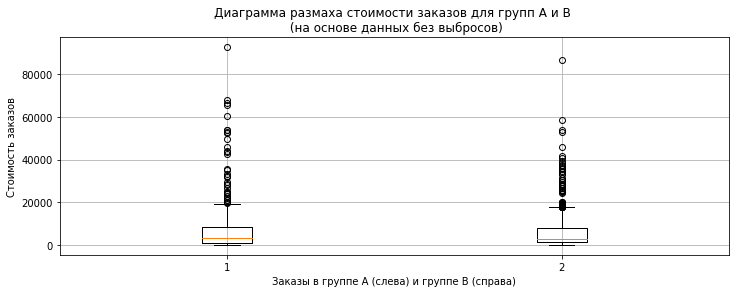

In [62]:
plt.figure(figsize=(12, 4))
plt.boxplot([orders_A_filtered, orders_B_filtered])
plt.title("Диаграмма размаха стоимости заказов для групп A и B \n (на основе данных без выбросов)")
plt.xlabel("Заказы в группе A (слева) и группе B (справа)")
plt.ylabel("Стоимость заказов") 
plt.grid()
plt.show()

Также наглядно сравнить можно, наложив две гистограммы заказов одну на другую - для групп A и B:

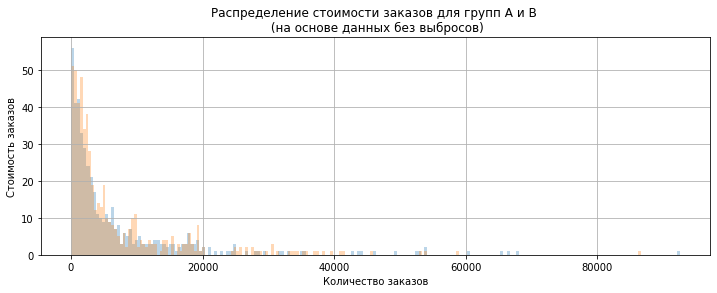

In [63]:
plt.figure(figsize=(12, 4))
plt.hist(orders_A_filtered, alpha=.3, bins=200)
plt.hist(orders_B_filtered, alpha=.3, bins=200)
plt.title("Распределение стоимости заказов для групп A и B \n (на основе данных без выбросов)")
plt.xlabel("Количество заказов")
plt.ylabel("Стоимость заказов") 
plt.grid()
plt.show()

И боксплоты, и гистограммы очень похожи. Визуально различий между ними практически нет. Критерий Манна-Уитни также не определил статистически значимых различий. Всё сходится.

Всё же, если посмотреть на график относительного изменения кумулятивного среднего чека группы B к группе A, то различие в -10% устанавливается уже с 13 августа и сохраняется до конца августа. Возможно, если мы будем проводить тест еще месяц или больше, и различие среднего чека будет сохраняться и далее, то критерий покажет нам значимое отличие. Так у нас родилась новая гипотеза, которую можно проверить, продлив тест еще, например, на месяц.

[К началу](#0)

#### <a name="14"> Кумулятивная конверсия </a>

Чтобы рассчитать кумулятивную конверсию, нужно поделить значения кумулятивных посетителей на значения кумулятивных заказов. У нас уже есть таблица с кумулятивными заказами - orders_cum. Составим таблицу с кумулятивными посетителями: 

In [64]:
visitors_cum = visitors.pivot_table(index='date', columns='group', values='visitors', aggfunc='mean')\
            .cumsum(axis=0)
visitors_cum.head()

group,A,B
date,,
2019-08-01,719,713
2019-08-02,1338,1294
2019-08-03,1845,1803
2019-08-04,2562,2573
2019-08-05,3318,3280


Теперь поделим значения в таблице orders_cum на соответстующие значения в таблице visitors_cum:

In [65]:
convertion = orders_cum / visitors_cum
convertion.tail()

group,A,B
date,,
2019-08-27,0.025586,0.028627
2019-08-28,0.025575,0.028818
2019-08-29,0.025702,0.028801
2019-08-30,0.025503,0.029179
2019-08-31,0.024979,0.028970


Построим график кумулятивной конверсии по "сырым" данным:

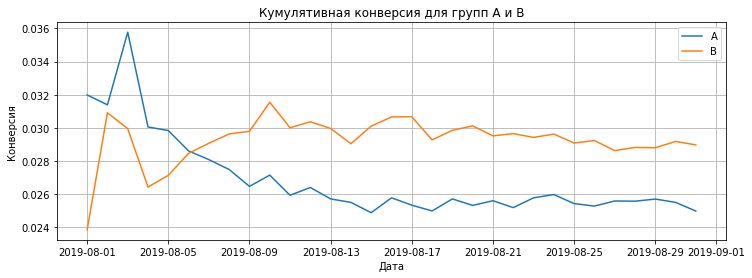

In [66]:
plt.figure(figsize=(12, 4))
plt.plot(convertion['A'], label='A')
plt.plot(convertion['B'], label='B')
plt.legend()
plt.title("Кумулятивная конверсия для групп A и B")
plt.xlabel("Дата")
plt.ylabel("Конверсия") 
plt.grid()
plt.show()

И график кумулятивной конверсии по "очищенным" данным:

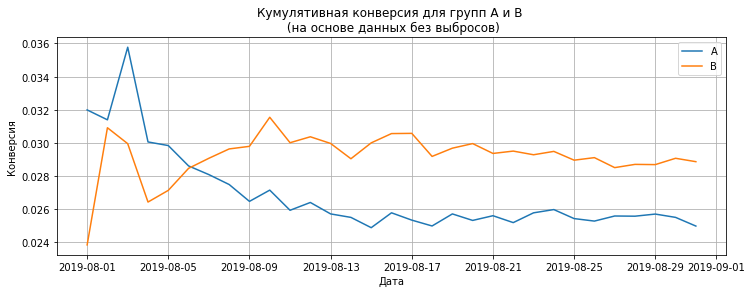

In [67]:
convertion_filtered = orders_cum_filtered / visitors_cum
plt.figure(figsize=(12, 4))
plt.plot(convertion_filtered['A'], label='A')
plt.plot(convertion_filtered['B'], label='B')
plt.legend()
plt.title("Кумулятивная конверсия для групп A и B \n (на основе данных без выбросов)")
plt.xlabel("Дата")
plt.ylabel("Конверсия") 
plt.grid()
plt.show()

В обоих случаях конверсия в группе B выше и сходится к 2,9%. Конверсия группы A сходится примерно к 2,5%.

Рассчитаем относительное изменение кумулятивной конверсии группы B к группе A по "сырым" данным:

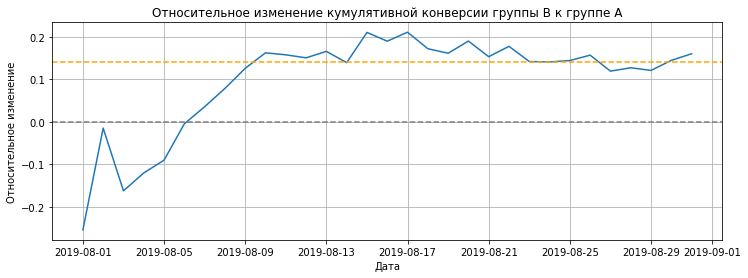

In [68]:
convertion['diff'] = (convertion['B'] - convertion['A']) / convertion['A']
plt.figure(figsize=(12, 4))
plt.plot(convertion['diff'])
plt.axhline(y=0, color='grey', linestyle='--') 
plt.axhline(y=.14, color='orange', linestyle='--') 
plt.title("Относительное изменение кумулятивной конверсии группы B к группе A")
plt.xlabel("Дата")
plt.ylabel("Относительное изменение") 
plt.grid()
plt.show()

И по "очищенным" данным:

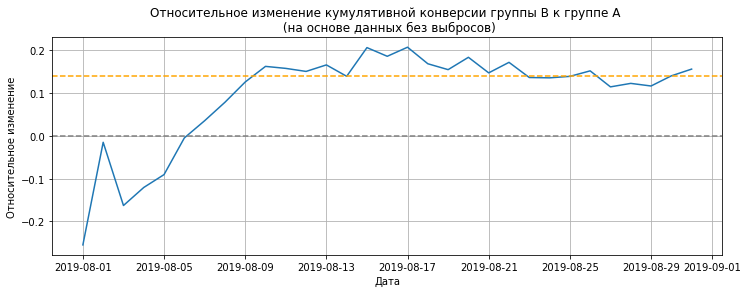

In [69]:
convertion_filtered['diff'] = (convertion_filtered['B'] - convertion_filtered['A']) \
                             / convertion_filtered['A']
plt.figure(figsize=(12, 4))
plt.plot(convertion_filtered['diff'])
plt.axhline(y=0, color='grey', linestyle='--')
plt.axhline(y=.14, color='orange', linestyle='--') 
plt.title("Относительное изменение кумулятивной конверсии группы B к группе A \n (на основе данных без выбросов)")
plt.xlabel("Дата")
plt.ylabel("Относительное изменение") 
plt.grid()
plt.show()

Различие сходится к 0,14 как по "сырым", так и по "очищенным" данным. То есть конверсия в группе B на 14% лучше, чем в группе A. 

Посчитаем статистическую значимость различий в конверсии между группами. Как нам уже известно, для этого нужно сделать три вещи:
- сформулировать нулевую и альтернативную гипотезу;
- выбрать статистический критерий, с помощью которого мы будем отвергать и принимать гипотезы;
- принять критическое значение альфа, которое определяет границу между значимыми и незначимыми различиями.

Сформулируем гипотезы: 

Нулевая гипотеза (H0): конверсии посетителей в заказы обеих групп относятся к общей генеральной совокупности с единой общей конверсией, а полученное различие в кумулятивной конверсии групп является случайным.

Альтернативная гипотеза (H1): конверсии в группах относятся к разным генеральным совокупностям. Полученное различие в кумулятивной конверсии групп вызвано тем, что она различается в генеральных совокупностях.

Проверку различий в конверсиях (или пропорциях, или долях) для разных выборок проводят с помощью z-значения - то есть значения, которое показывает на сколько стандартных отклонений наше различие в конверсиях отклоняется от нуля. Если принять нулевую гипотезу верной, то рассчитывается z-значение следующим образом:

$$z = \frac{(P_A - P_B)}{\sqrt{P(1-P)(1/n_A + 1/n_B)}}$$

где $P_A$ и $P_B$ - конверсия в группах, $P$ - общая конверсия для двух групп, $n_A$ и $n_B$ - количество посетителей в группах.

Критическим значением альфа примем 0,05.

In [70]:
alpha = .05

Напишем функцию, которая найдёт p-уровень значимости на основе рассчитанного по формуле выше z-значения:

In [71]:
def find_pvalue(convertion_type, orders_cum_type):
    p_A = convertion_type['A'][-1] # посчитаем конверсию в группе A 
    p_B = convertion_type['B'][-1] # посчитаем конверсию в группе B 
    n_A = visitors_cum['A'][-1] # посчитаем количество посетителей в группе A 
    n_B = visitors_cum['B'][-1] # посчитаем количество посетителей в группе B
    p = (orders_cum_type['A'][-1] + orders_cum_type['B'][-1]) / (n_A + n_B) # посчитаем общую конверсию для обеих групп
    z_value = (p_A - p_B) / (p * (1 - p) * (1 / n_A + 1 / n_B))**.5 # найдём z-значение
    distr = st.norm(0, 1) # зададим стандартное нормальное распределение \
    p_value = (1 - distr.cdf(abs(z_value))) * 2 # рассчитаем вероятность получить отклонение равное z-значению
    return p_value

Посчитаем p-уровень значимости для "сырых" и "очищенных" данных:

In [72]:
p_value = find_pvalue(convertion, orders_cum) # для "сырых" данных
p_value_filtered = find_pvalue(convertion_filtered, orders_cum_filtered) # для "очищенных" данных

Воспользуемся написанной ранее функцией conclusion_by, которая выдаст результат проверки для разных типов данных:

In [73]:
conclusion_by(p_value, 'сырым')

Результат проверки по сырым данным:
P-уровень значимости составил 0.02. Это меньше критического значения альфа, равного 0.05.
Поэтому отвергаем нулевую гипотезу и принимаем альтернативную. Различие является статистически значимым.


In [74]:
conclusion_by(p_value_filtered, 'очищенным')

Результат проверки по очищенным данным:
P-уровень значимости составил 0.02. Это меньше критического значения альфа, равного 0.05.
Поэтому отвергаем нулевую гипотезу и принимаем альтернативную. Различие является статистически значимым.


На основе "сырых" и "очищенных" данных нам удалось отклонить нулевую гипотезу и доказать статистическую значимость в различии конверсий в группах при альфа, равном 0,05. В тестовой группе посетители лучше конвертируются в заказы, чем в контрольной группе на 14%.

Рассчитать p-уровень значимости также можно, воспользовавшись функцией proportions_ztest библиотеки statsmodels.stats.proportion. Проверим себя, сделаем расчёт для "очищенных" данных:

In [75]:
count = [orders_cum_filtered['A'][-1], orders_cum_filtered['B'][-1]]
nobs = [visitors_cum['A'][-1], visitors_cum['B'][-1]]
p_value_filtered_2 = proportions_ztest(count, nobs)[1]
conclusion_by(p_value_filtered, 'очищенным')

Результат проверки по очищенным данным:
P-уровень значимости составил 0.02. Это меньше критического значения альфа, равного 0.05.
Поэтому отвергаем нулевую гипотезу и принимаем альтернативную. Различие является статистически значимым.


Результат совпадает.

### <a name="15"> Выводы по итогам анализа A/B-теста </a>

По итогам проведённого A/B-теста можно сделать следующие заключения:
- в группах A и B оказалось практически равное количество посетителей (с небольшой разницей меньше 1%), при этом группы наполнялись с равной скоростью между собой в течение всех дней месяца;
- 58 покупателей попали сразу в две группы: A и B. К сожалению, их пришлось исключить из теста. Где-то на этапе разделения пользователей на группы была совершена ошибка и часть пользователей видели сразу две версии сайта. Надо проверить, что в таблице visitors нет посетителей, которые бы попали и в группу A, и в группу B; 
- среди данных были найдены выбросы - заказы дороже 100 000 - 2 из 1016 заказов. Они были исключены из анализа результатов теста. Покупателей с необычно большим числом заказов в данных не найдено: клиенты делали от 1 до 3 заказов;
- накопленная выручка в группе B на 51% выше, чем в группе A - на основе "сырых" данных. Такое отличие вызвано выбросом в виде заказа стоимостью 1 294 500. Накопленная выручка на основе "очищенных" данных в группе B на 6% выше, чем в группе A. Если делать поправку на различие в размере групп, то будем считать прирост выручку равным 5%;
- средний чек группы B оказался ниже среднего чека группы A примерно на 10% по "очищенным" данным. Различие оказалось статистически не значимым. Однако, если продлить тест еще на месяц, то различие может стать значимым. 
- конверсия тестовой группы оказалась выше конверсии контрольной группы на 14% как по "сырым", так и по "очищенным" данным. Различие является статистически значимым при критическом значении альфа, равном 5%.

Мы выяснили, что конверсия в тестовой группе выросла статистически значимо. Однако средний чек упал (не доказано, что статистически значимо). В связи с этим и кумулятивная выручка выросла не сильно - всего на 5%. Чтобы не получилось так, что при выборе тестовой версии сайта в будущем конверсия вырастет, а средний чек упадёт, и эти изменения компенсируют друг друга, предлагаю продлить A/B-тест еще на один месяц. Так мы проверим, действительно ли в ходе A/B-теста средний чек в тестовой группе упал случайно. И проверим, действительно ли полученный прирост конверсии приведёт нас к увеличению кумулятивной выручки, к чему мы стремимся.

[К началу](#0)